In [ ]:
pip install pandas numpy tensorflow tensorflow-hub

In [ ]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
train_df = pd.read_csv("train.csv")

In [ ]:
# Combine text fields
train_df['text'] = train_df['question_title'] + ' ' + train_df['question_content'] + ' ' + train_df['best_answer']

# Clean function
def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'http\S+|www.\S+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['clean_text'] = train_df['text'].astype(str).apply(clean_text)

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Convert class labels to integers then to one-hot
labels = train_df['class_index'].values
labels = to_categorical(labels, num_classes=12)  # 12 classes (0–11)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    train_df['clean_text'].values,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)
import numpy as np

# Ensure data is in correct object format for string-based input
X_train = np.array(X_train, dtype=object)
X_val = np.array(X_val, dtype=object)

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Lambda  # Import Lambda

# Load the embedding layer
hub_url = "https://tfhub.dev/google/nnlm-en-dim128/2"
hub_layer = hub.KerasLayer(hub_url, input_shape=[], dtype=tf.string, trainable=True)

# Functional API Model (to support non-standard layers like TFHub)
input_text = tf.keras.Input(shape=(), dtype=tf.string, name="input_text")
x = Lambda(lambda x: hub_layer(tf.cast(x, tf.string)))(input_text)  # Wrap in Lambda
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(12, activation='softmax')(x)

model_1 = Model(inputs=input_text, outputs=output)

# Compile the model
model_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_text (InputLayer)              │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,060 (70.55 KB)

 Trainable params: 18,060 (70.55 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model_1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=32,
    verbose=1
)

Epoch 1/3
35000/35000 ━━━━━━━━━━━━━━━━━━━━ 1070s 31ms/step - accuracy: 0.4054 - loss: 1.6470 - val_accuracy: 0.4309 - val_loss: 1.5648
Epoch 2/3
35000/35000 ━━━━━━━━━━━━━━━━━━━━ 1077s 31ms/step - accuracy: 0.4272 - loss: 1.5776 - val_accuracy: 0.4312 - val_loss: 1.5569
Epoch 3/3
35000/35000 ━━━━━━━━━━━━━━━━━━━━ 1078s 31ms/step - accuracy: 0.4290 - loss: 1.5728 - val_accuracy: 0.4359 - val_loss: 1.5519


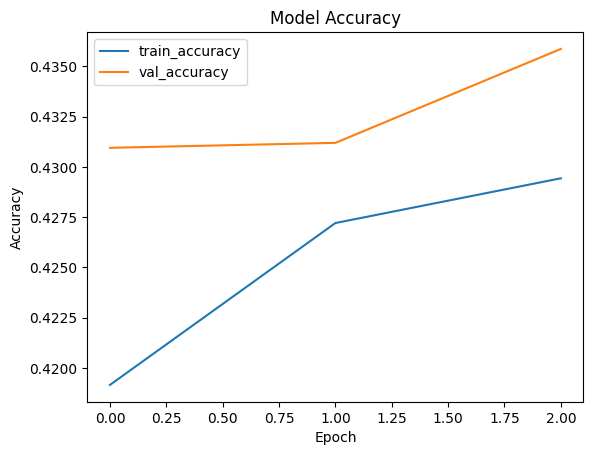

In [8]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

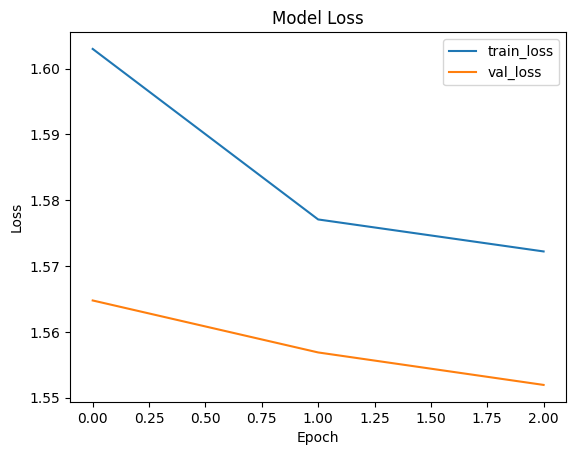

In [9]:
# Loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [10]:
val_loss, val_acc = model_1.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")

8750/8750 ━━━━━━━━━━━━━━━━━━━━ 69s 8ms/step - accuracy: 0.4365 - loss: 1.5496
Validation Accuracy: 0.4359, Validation Loss: 1.5519


In [11]:
import pandas as pd
import numpy as np

# Load test data
test_df = pd.read_csv("test.csv")

# Use 'question_content' as the input text
test_texts = test_df['question_content'].astype(str).values
test_texts = np.array(test_texts, dtype=object)

In [12]:
# Predict
predictions = model_1.predict(test_texts)

# Get predicted class labels
predicted_classes = np.argmax(predictions, axis=1)

# Show the results
print(predicted_classes)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
[2 6 7 ... 7 7 8]


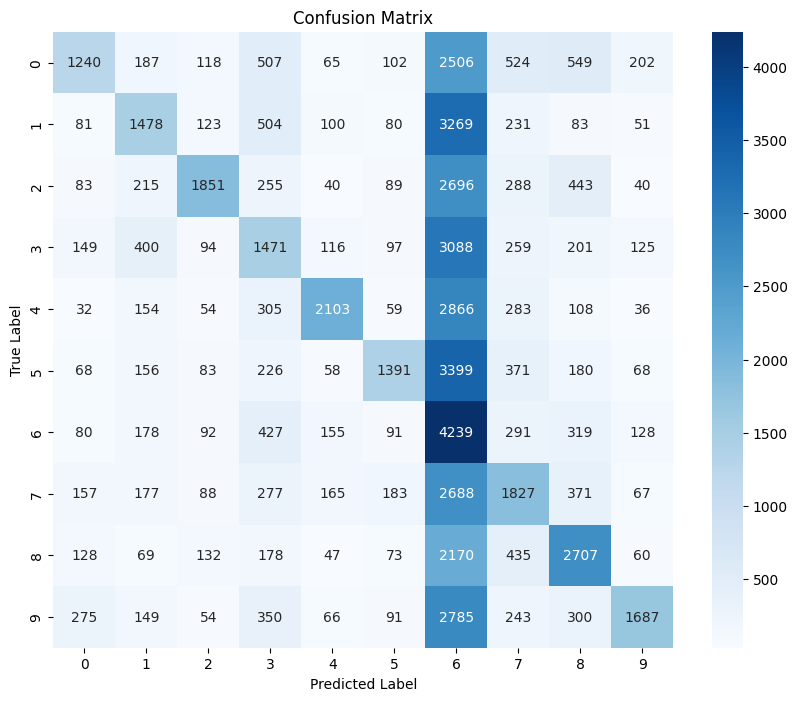

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Ensure ground truth is available
true_labels = test_df['class_index'].values
pred_labels = predicted_classes

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

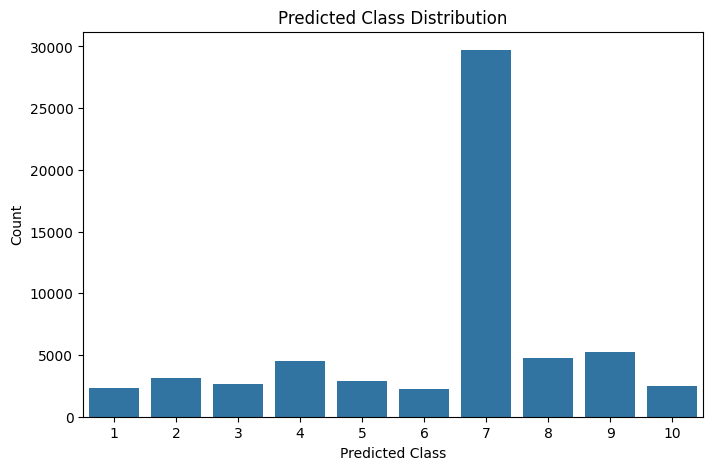

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot predicted class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=predicted_classes)
plt.title("Predicted Class Distribution")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.show()

In [15]:
import numpy as np
import pandas as pd

# Get top 5 highest confidence predictions
confidences = np.max(predictions, axis=1)
top_indices = np.argsort(confidences)[-5:][::-1]

top_preds = pd.DataFrame({
    'Text': test_texts[top_indices],
    'Predicted Class': predicted_classes[top_indices],
    'Confidence': confidences[top_indices]
})
top_preds

,Text,Predicted Class,Confidence
0,FSX System Requirements \nWindows XP SP2 / Win...,5,1.0
1,I have a 200GB Western Digital HD with a USB-t...,5,1.0
2,Module Description Show Details \nInspiron ...,5,1.0
3,Conference leaders: Bears (9-1) Cowboys (7-4) ...,6,1.0
4,Atlanta Falcons football tickets,6,1.0


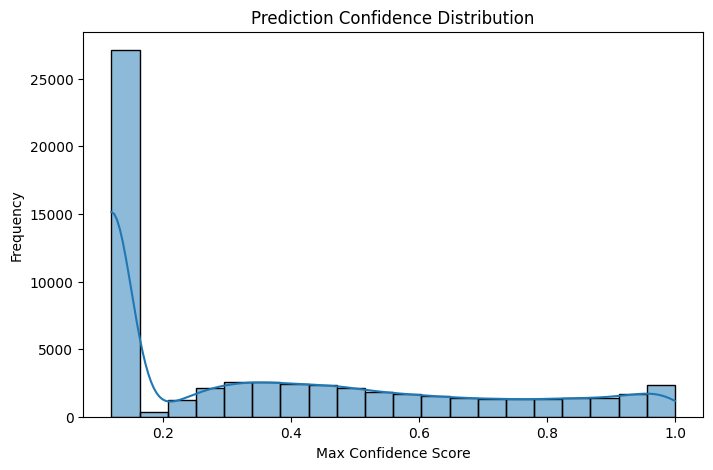

In [16]:
plt.figure(figsize=(8, 5))
sns.histplot(confidences, bins=20, kde=True)
plt.title("Prediction Confidence Distribution")
plt.xlabel("Max Confidence Score")
plt.ylabel("Frequency")
plt.show()

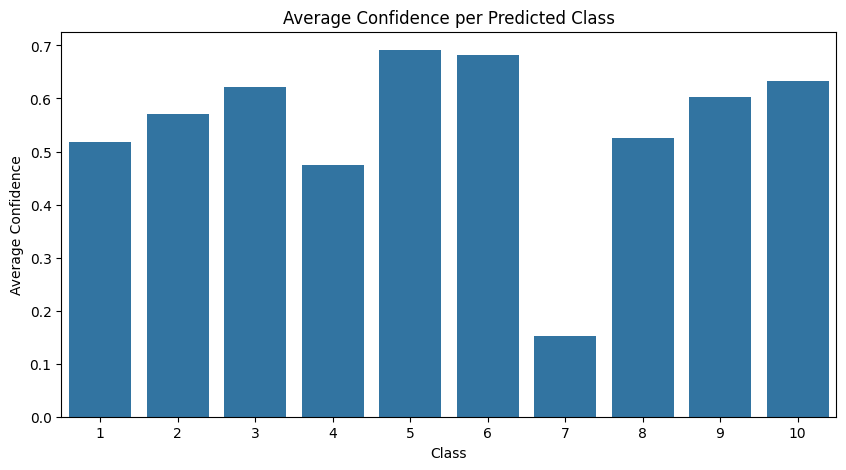

In [17]:
avg_conf_per_class = pd.DataFrame({'class': predicted_classes, 'confidence': confidences})
avg_confidence = avg_conf_per_class.groupby('class').mean()

plt.figure(figsize=(10, 5))
sns.barplot(x=avg_confidence.index, y=avg_confidence['confidence'])
plt.title("Average Confidence per Predicted Class")
plt.xlabel("Class")
plt.ylabel("Average Confidence")
plt.show()

In [18]:
import tensorflow_hub as hub
from tensorflow.keras import layers, Model
import tensorflow as tf

# Load USE layer
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           input_shape=[], dtype=tf.string, trainable=False, name="USE")

# Build USE model
# Wrap the USE layer call in a Lambda layer to handle KerasTensors
def use_call(input_tensor):
    return use_layer(tf.cast(input_tensor, tf.string))

input_text = tf.keras.Input(shape=(), dtype=tf.string, name="input_text")
x = layers.Lambda(use_call)(input_text)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(12, activation='softmax')(x)

model_2 = Model(inputs=input_text, outputs=output)

model_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_text (InputLayer)              │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,212 (262.55 KB)

 Trainable params: 67,212 (262.55 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history_2 = model_2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=32,
    verbose=1
)

Epoch 1/3
35000/35000 ━━━━━━━━━━━━━━━━━━━━ 1832s 52ms/step - accuracy: 0.4489 - loss: 1.5220 - val_accuracy: 0.4651 - val_loss: 1.4529
Epoch 2/3
35000/35000 ━━━━━━━━━━━━━━━━━━━━ 1861s 52ms/step - accuracy: 0.4643 - loss: 1.4595 - val_accuracy: 0.4666 - val_loss: 1.4494
Epoch 3/3
35000/35000 ━━━━━━━━━━━━━━━━━━━━ 1813s 51ms/step - accuracy: 0.4668 - loss: 1.4545 - val_accuracy: 0.4676 - val_loss: 1.4468


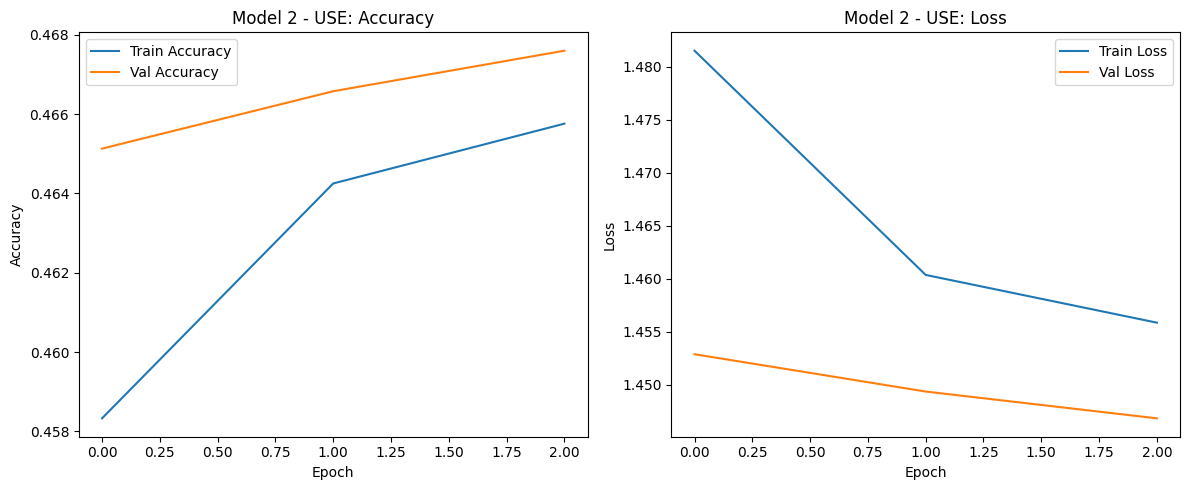

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 1. Plot accuracy/loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Val Accuracy')
plt.title('Model 2 - USE: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Val Loss')
plt.title('Model 2 - USE: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

8750/8750 ━━━━━━━━━━━━━━━━━━━━ 251s 29ms/step


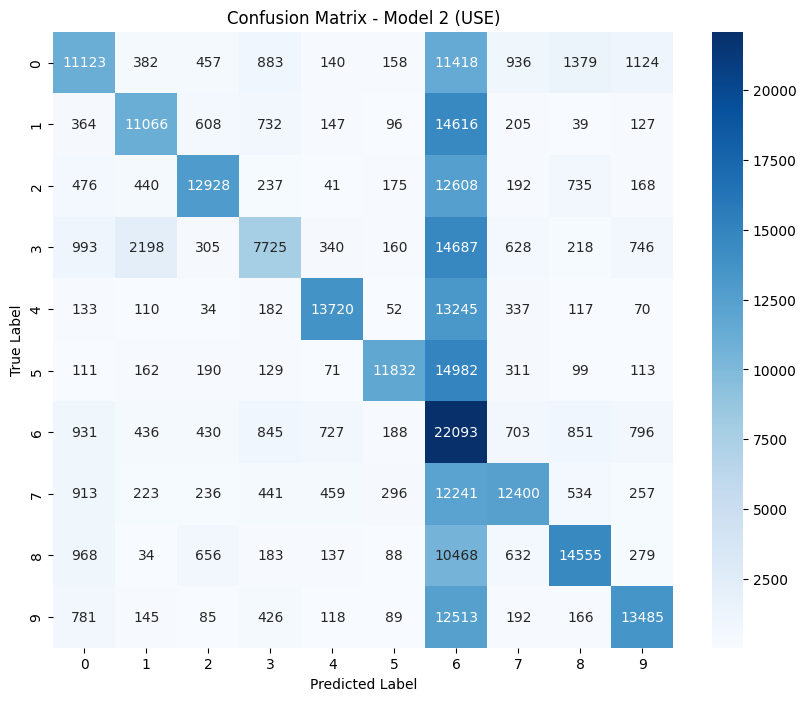

Classification Report - Model 2 (USE):
               precision    recall  f1-score   support

           1      0.662     0.397     0.497     28000
           2      0.728     0.395     0.512     28000
           3      0.812     0.462     0.589     28000
           4      0.656     0.276     0.388     28000
           5      0.863     0.490     0.625     28000
           6      0.901     0.423     0.575     28000
           7      0.159     0.789     0.265     28000
           8      0.750     0.443     0.557     28000
           9      0.779     0.520     0.623     28000
          10      0.786     0.482     0.597     28000

    accuracy                          0.468    280000
   macro avg      0.709     0.468     0.523    280000
weighted avg      0.709     0.468     0.523    280000



In [21]:
# Predict
y_pred_probs = model_2.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Model 2 (USE)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, digits=3)
print("Classification Report - Model 2 (USE):\n", report)

In [4]:
from tensorflow.keras.layers import TextVectorization
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
import re

# Parameters
vocab_size = 10000
sequence_length = 100

# Load and preprocess data
train_df = pd.read_csv("train.csv")
train_df['text'] = train_df['question_title'] + ' ' + train_df['question_content'] + ' ' + train_df['best_answer']

def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'http\S+|www.\S+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['clean_text'] = train_df['text'].astype(str).apply(clean_text)

labels = train_df['class_index'].values
labels = to_categorical(labels, num_classes=12)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    train_df['clean_text'].values,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)
X_train = np.array(X_train, dtype=object)
X_val = np.array(X_val, dtype=object)

# Vectorization layer
vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length
)

# Adapt it to the training text
vectorize_layer.adapt(X_train)

In [7]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
import tensorflow as tf # Import tensorflow

model_3 = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(input_dim=vocab_size, output_dim=128),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(12, activation='softmax')  # 12 classes
])

model_3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_2                 │ (None, 100)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,298,060 (4.95 MB)

 Trainable params: 1,298,060 (4.95 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history_3 = model_3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=32,
    verbose=1
)

Epoch 1/3
35000/35000 ━━━━━━━━━━━━━━━━━━━━ 1332s 38ms/step - accuracy: 0.3901 - loss: 1.6928 - val_accuracy: 0.4458 - val_loss: 1.5147
Epoch 2/3
35000/35000 ━━━━━━━━━━━━━━━━━━━━ 1346s 38ms/step - accuracy: 0.4468 - loss: 1.5190 - val_accuracy: 0.4499 - val_loss: 1.5126
Epoch 3/3
35000/35000 ━━━━━━━━━━━━━━━━━━━━ 1318s 38ms/step - accuracy: 0.4517 - loss: 1.5010 - val_accuracy: 0.4495 - val_loss: 1.5137


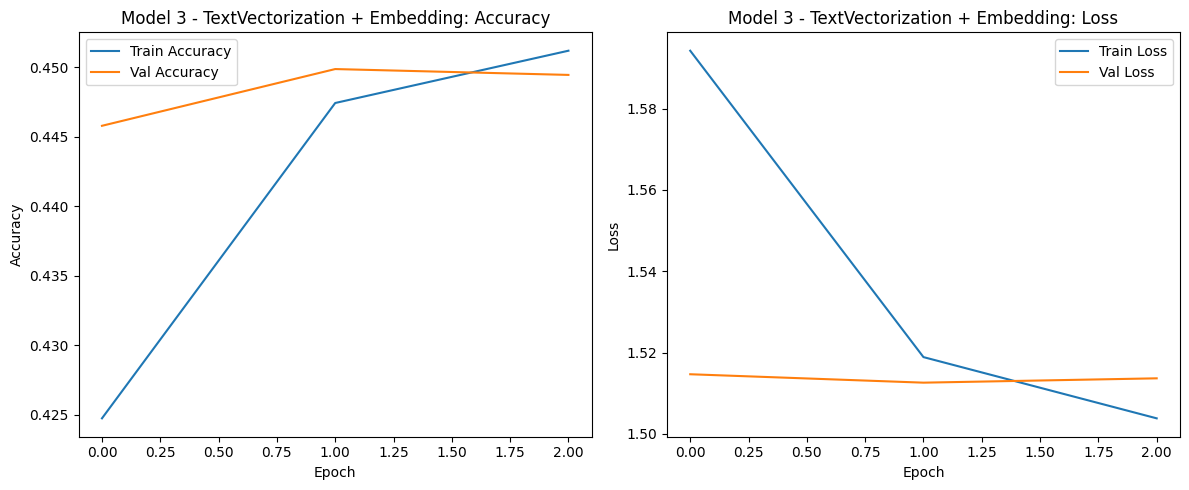

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Accuracy & loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_3.history['accuracy'], label='Train Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Val Accuracy')
plt.title('Model 3 - TextVectorization + Embedding: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_3.history['loss'], label='Train Loss')
plt.plot(history_3.history['val_loss'], label='Val Loss')
plt.title('Model 3 - TextVectorization + Embedding: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

8750/8750 ━━━━━━━━━━━━━━━━━━━━ 71s 8ms/step


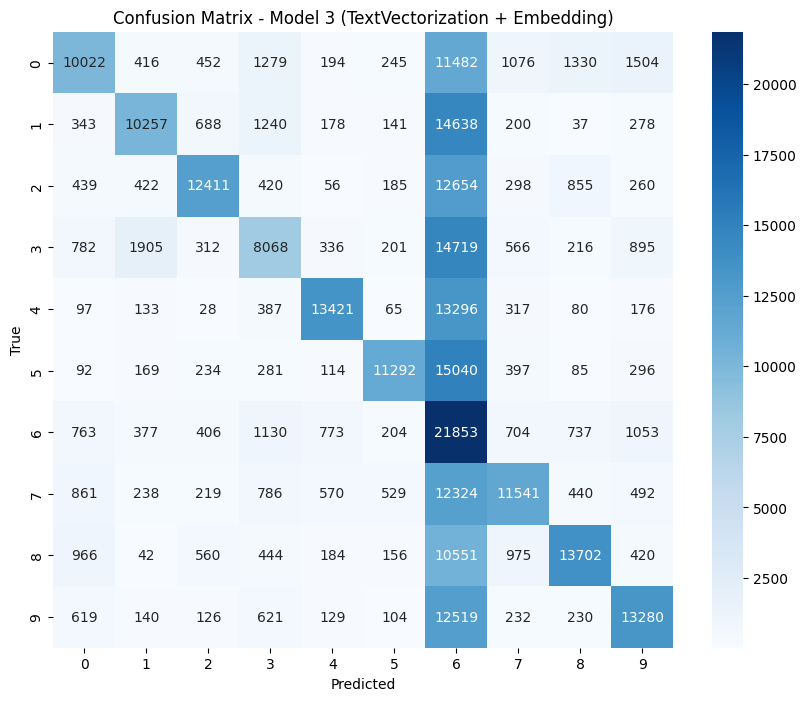

Classification Report - Model 3:
               precision    recall  f1-score   support

           1      0.669     0.358     0.466     28000
           2      0.727     0.366     0.487     28000
           3      0.804     0.443     0.571     28000
           4      0.550     0.288     0.378     28000
           5      0.841     0.479     0.611     28000
           6      0.861     0.403     0.549     28000
           7      0.157     0.780     0.262     28000
           8      0.708     0.412     0.521     28000
           9      0.774     0.489     0.599     28000
          10      0.712     0.474     0.569     28000

    accuracy                          0.449    280000
   macro avg      0.680     0.449     0.501    280000
weighted avg      0.680     0.449     0.501    280000



In [10]:
# Predict
y_pred_probs_3 = model_3.predict(X_val)
y_pred_3 = np.argmax(y_pred_probs_3, axis=1)
y_true_3 = np.argmax(y_val, axis=1)

# Confusion Matrix
cm3 = confusion_matrix(y_true_3, y_pred_3)
plt.figure(figsize=(10, 8))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Model 3 (TextVectorization + Embedding)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification report
report_3 = classification_report(y_true_3, y_pred_3, digits=3)
print("Classification Report - Model 3:\n", report_3)